# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math
import cv2

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [18]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.5
ROT_ACCURACY = 0.06
CHECK_ANGLE = math.pi / 4.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [19]:
# Open camera
cap = cv2.VideoCapture(0)
if cap.isOpened() == False:
    print("Erreur: Impossible d'ouvrir la webcam.")

time.sleep(2)
ret, frame = cap.read()
    
if ret == False:
    print("Erreur: Impossible de capturer l'image.")


In [20]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [21]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [22]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(739, 956), (1089, 956), (1089, 427), (739, 427)], [(475, 1080), (993, 1080), (993, 663), (475, 663)]]
Centroid de la goal area : [1631.   571.5]
Vecteur direction du robot : 95 -5
Centroid du robot : [474 583]


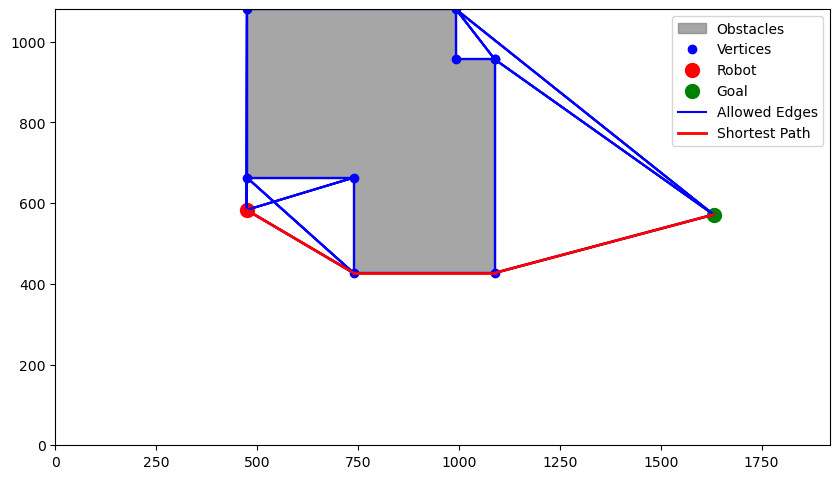

In [23]:
ret, frame = cap.read()

# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal(frame)
robot_centroid, robot_direction = vision.vision_robot(frame)

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot(frame)

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  x:  25.0 , y:  31.0 , angle:  -0.05258306161094172
Rotation state:
Robot angle:  [-0.05258306] , Goal angle:  [-0.51914611] , Rotation to achieve:  [-0.46656305]
Iteration :  2
Kalman:  x:  25.249484256244397 , y:  30.986869249671347 , angle:  -0.052935154637883224
Rotation state:
Robot angle:  [-0.05293515] , Goal angle:  [-0.52621319] , Rotation to achieve:  [-0.47327803]
Iteration :  3
Kalman:  x:  25.716707155754467 , y:  30.966790333614576 , angle:  -0.07939337224428238
Rotation state:
Robot angle:  [-0.07939337] , Goal angle:  [-0.54024316] , Rotation to achieve:  [-0.46084978]
Iteration :  4
Kalman:  x:  25.86807852170414 , y:  30.956633972346143 , angle:  -0.1490940841794944
Rotation state:
Robot angle:  [-0.14909408] , Goal angle:  [-0.5447466] , Rotation to achieve:  [-0.39565251]
Iteration :  5
Kalman:  x:  25.920872597559267 , y:  30.948156753330764 , angle:  -0.23680697853114924
Rotation state:
Robot angle:  [-0.23680698] , Goal angle:  [-0.54606042

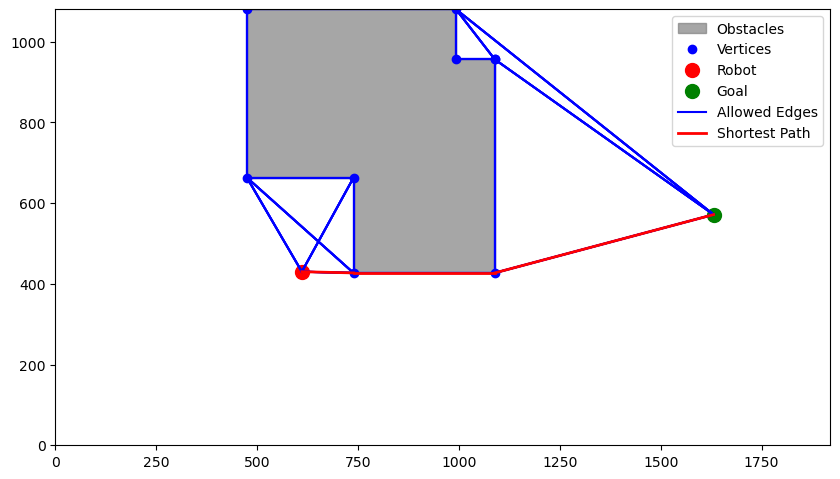

centroid camera:  (33, 23)
glob nav path : [(39, 23), (58, 23), (88, 30)]
Iteration :  26
Kalman:  x:  33.00065423823433 , y:  22.999976624708182 , angle:  -0.7216764464096148
Rotation state:
Robot angle:  [-0.72167645] , Goal angle:  [3.89630682e-06] , Rotation to achieve:  [0.72168034]
Iteration :  27
Kalman:  x:  33.33452457485835 , y:  22.70614403924102 , angle:  -0.7103812757838669
Rotation state:
Robot angle:  [-0.71038128] , Goal angle:  [0.0518214] , Rotation to achieve:  [0.76220268]
Iteration :  28
Kalman:  x:  33.49894548059028 , y:  22.562784108961477 , angle:  -0.6741393566010045
Rotation state:
Robot angle:  [-0.67413936] , Goal angle:  [0.07931184] , Rotation to achieve:  [0.7534512]
Iteration :  29
Kalman:  x:  33.566040743171385 , y:  22.508529268519965 , angle:  -0.60576376406165
Rotation state:
Robot angle:  [-0.60576376] , Goal angle:  [0.0901989] , Rotation to achieve:  [0.69596267]
Iteration :  30
Kalman:  x:  33.591600626818426 , y:  22.49141803082469 , angle:  -

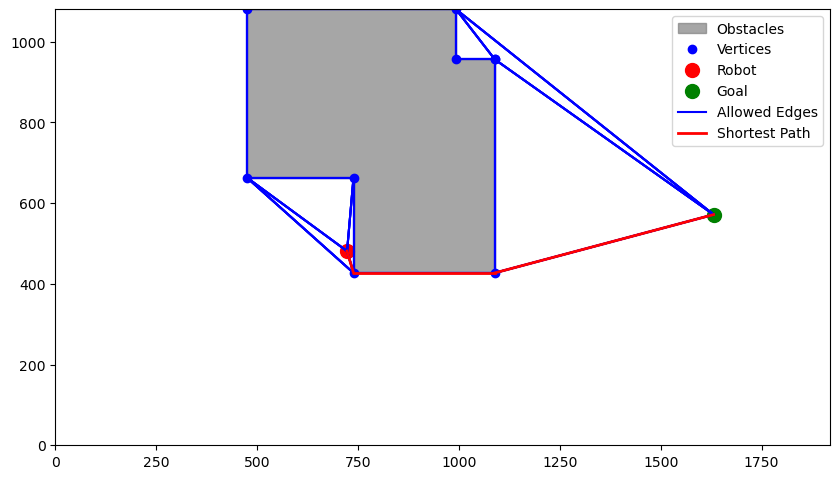

centroid camera:  (39, 26)
glob nav path : [(39, 23), (58, 23), (88, 30)]
Iteration :  47
Kalman:  x:  38.999823317431485 , y:  25.998463943982845 , angle:  0.16766577313922146
Rotation state:
Robot angle:  [0.16766577] , Goal angle:  [-1.5707374] , Rotation to achieve:  [-1.73840318]
Iteration :  48
Kalman:  x:  39.44585223605481 , y:  26.07396735301934 , angle:  0.17569282839927533
Rotation state:
Robot angle:  [0.17569283] , Goal angle:  [-1.7148332] , Rotation to achieve:  [-1.89052603]
Iteration :  49
Kalman:  x:  39.71365273345957 , y:  26.122798432420716 , angle:  0.16771484669143127
Rotation state:
Robot angle:  [0.16771485] , Goal angle:  [-1.795468] , Rotation to achieve:  [-1.96318285]
Iteration :  50
Kalman:  x:  39.85715607654821 , y:  26.15021778966323 , angle:  0.11813947875229955
Rotation state:
Robot angle:  [0.11813948] , Goal angle:  [-1.83645906] , Rotation to achieve:  [-1.95459854]
Iteration :  51
Kalman:  x:  39.931653074741256 , y:  26.15946271336013 , angle:  0

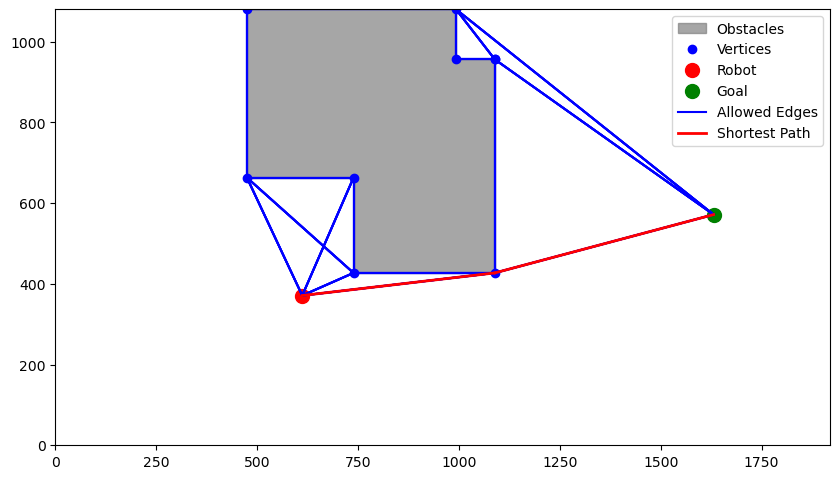

centroid camera:  (33, 20)
glob nav path : [(58, 23), (88, 30)]
Iteration :  80
Kalman:  x:  33.001253446523165 , y:  20.000599814693043 , angle:  -2.0751219935206775
Rotation state:
Robot angle:  [-2.07512199] , Goal angle:  [0.1194112] , Rotation to achieve:  [2.1945332]
Iteration :  81
Kalman:  x:  32.76785507219491 , y:  19.577729042271933 , angle:  -2.0767669866891074
Rotation state:
Robot angle:  [-2.07676699] , Goal angle:  [0.13480877] , Rotation to achieve:  [2.21157575]
Iteration :  82
Kalman:  x:  32.65945008378715 , y:  19.38659380079602 , angle:  -2.0531274101994463
Rotation state:
Robot angle:  [-2.05312741] , Goal angle:  [0.141639] , Rotation to achieve:  [2.19476641]
Iteration :  83
Kalman:  x:  32.621717319253385 , y:  19.31649088992742 , angle:  -1.9912798783969454
Rotation state:
Robot angle:  [-1.99127988] , Goal angle:  [0.14413759] , Rotation to achieve:  [2.13541747]
Iteration :  84
Kalman:  x:  32.607928984464586 , y:  19.28574516919122 , angle:  -1.90927990446

Iteration :  124
Kalman:  x:  48.28463306798657 , y:  24.172760464548375 , angle:  0.31319660985760434
Translation state:
Error =  [9.78589402]
Iteration :  125
Kalman:  x:  49.366965486111 , y:  24.522734333219464 , angle:  0.3086593464074814
Translation state:
Error =  [8.76629938]
Iteration :  126
Kalman:  x:  50.45138095004514 , y:  24.868294473977233 , angle:  0.30492915263153475
Translation state:
Error =  [7.77638565]
Iteration :  127
Kalman:  x:  51.53862912637529 , y:  25.209928586337067 , angle:  0.3020853709724447
Translation state:
Error =  [6.82884309]
Iteration :  128
Kalman:  x:  52.58473661319409 , y:  25.535202864444713 , angle:  0.30062909947923483
Translation state:
Error =  [5.97932531]
Iteration :  129
Kalman:  x:  53.63438100779661 , y:  25.857701560888135 , angle:  0.30382324025082075
Translation state:
Error =  [5.21776651]
Iteration :  130
Kalman:  x:  53.89545464510068 , y:  25.940400573800606 , angle:  0.3040899704264198
Camera state:
Vecteur direction du rob

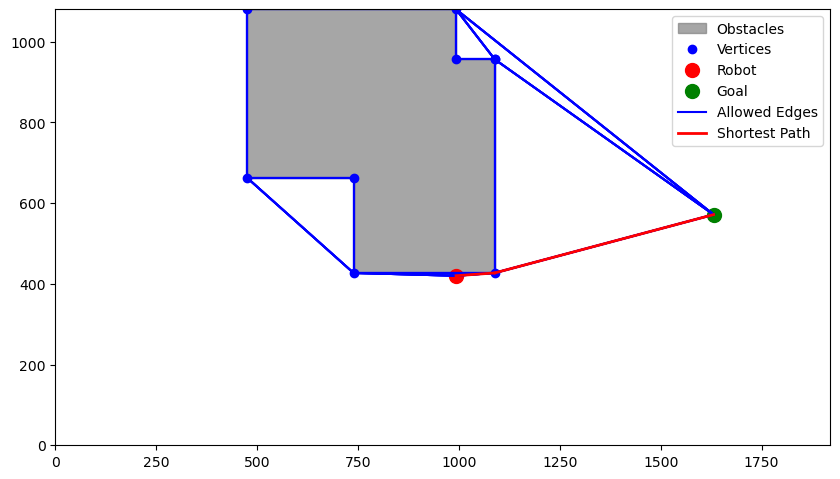

centroid camera:  (53, 22)
glob nav path : [(58, 23), (88, 30)]
Iteration :  131
Kalman:  x:  53.00010665333527 , y:  22.000375429585297 , angle:  0.05777032431671236
Rotation state:
Robot angle:  [0.05777032] , Goal angle:  [0.19732746] , Rotation to achieve:  [0.13955714]
Iteration :  132
Kalman:  x:  53.37798880553788 , y:  22.02222738359358 , angle:  0.056961982419330176
Rotation state:
Robot angle:  [0.05696198] , Goal angle:  [0.20847339] , Rotation to achieve:  [0.15151141]
Iteration :  133
Kalman:  x:  53.5415640885657 , y:  22.029861944949836 , angle:  0.08402186900280616
Rotation state:
Robot angle:  [0.08402187] , Goal angle:  [0.21425618] , Rotation to achieve:  [0.13023431]
Iteration :  134
Kalman:  x:  53.60882468945613 , y:  22.034914834999334 , angle:  0.14893213882519032
Rotation state:
Robot angle:  [0.14893214] , Goal angle:  [0.21633886] , Rotation to achieve:  [0.06740672]
Iteration :  135
Kalman:  x:  53.63935891986054 , y:  22.039722270687815 , angle:  0.23201833

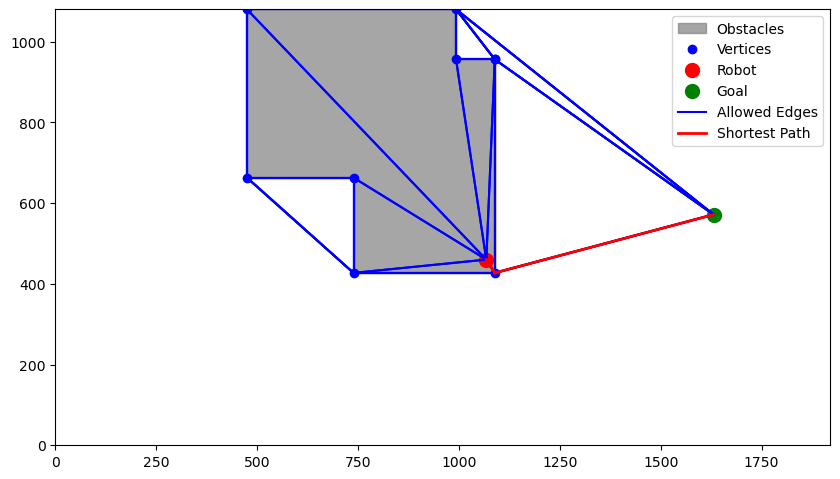

centroid camera:  (57, 24)
glob nav path : [(58, 23), (88, 30)]
Iteration :  144
Kalman:  x:  57.00094735025127 , y:  23.997324910040476 , angle:  0.3421366156455667
Rotation state:
Robot angle:  [0.34213662] , Goal angle:  [-0.78453273] , Rotation to achieve:  [-1.12666934]
Iteration :  145
Kalman:  x:  57.40530619629215 , y:  24.141349566243562 , angle:  0.3569595984526932
Rotation state:
Robot angle:  [0.3569596] , Goal angle:  [-1.09045528] , Rotation to achieve:  [-1.44741488]
Iteration :  146
Kalman:  x:  57.66463827141876 , y:  24.23939955041327 , angle:  0.35519262954357383
Rotation state:
Robot angle:  [0.35519263] , Goal angle:  [-1.30654022] , Rotation to achieve:  [-1.66173285]
Iteration :  147
Kalman:  x:  57.80309626179325 , y:  24.294655517993316 , angle:  0.3105421909914677
Rotation state:
Robot angle:  [0.31054219] , Goal angle:  [-1.41986332] , Rotation to achieve:  [-1.73040551]
Iteration :  148
Kalman:  x:  57.84160356086523 , y:  24.30732393149598 , angle:  0.23257

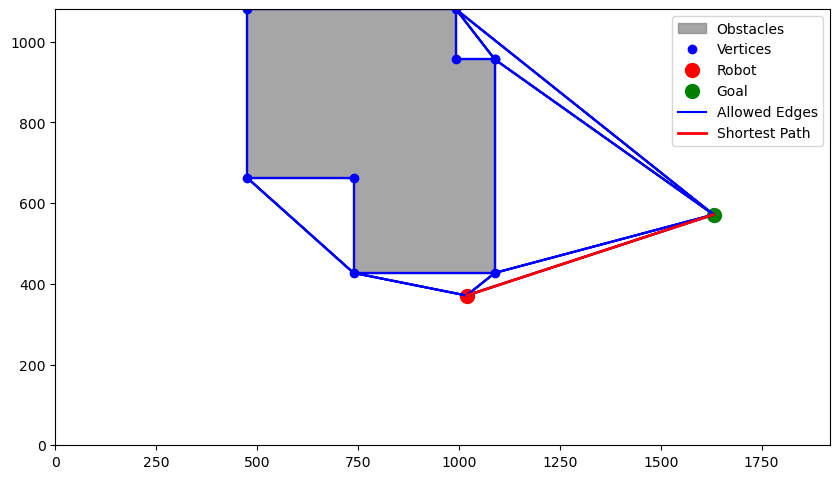

centroid camera:  (55, 20)
glob nav path : [(88, 30)]
Iteration :  171
Kalman:  x:  55.000909381481414 , y:  20.001281332645075 , angle:  -1.5995585791761981
Rotation state:
Robot angle:  [-1.59955858] , Goal angle:  [0.29420665] , Rotation to achieve:  [1.89376523]
Iteration :  172
Kalman:  x:  54.97195126850005 , y:  18.994798209913313 , angle:  -1.593263294543444
Rotation state:
Robot angle:  [-1.59326329] , Goal angle:  [0.32163752] , Rotation to achieve:  [1.91490082]
Iteration :  173
Kalman:  x:  54.9531206534052 , y:  18.34295794066406 , angle:  -1.5676219304749335
Rotation state:
Robot angle:  [-1.56762193] , Goal angle:  [0.33911602] , Rotation to achieve:  [1.90673795]
Iteration :  174
Kalman:  x:  54.95124563902209 , y:  18.093423683576717 , angle:  -1.5083726620937008
Rotation state:
Robot angle:  [-1.50837266] , Goal angle:  [0.3457973] , Rotation to achieve:  [1.85416997]
Iteration :  175
Kalman:  x:  54.95695517010083 , y:  18.006447009072954 , angle:  -1.426875295703783

Iteration :  217
Kalman:  x:  73.3531606986552 , y:  29.619244116077276 , angle:  0.5842194772167913
Translation state:
Error =  [14.65178749]
Iteration :  218
Kalman:  x:  74.2685146812967 , y:  30.224650978295205 , angle:  0.5845366267667593
Translation state:
Error =  [13.73332287]
Iteration :  219
Kalman:  x:  75.20302982835554 , y:  30.845606567287085 , angle:  0.5815282033854281
Translation state:
Error =  [12.82487801]
Iteration :  220
Kalman:  x:  76.13399476713796 , y:  31.456000979129115 , angle:  0.5784651456794914
Translation state:
Error =  [11.95499975]
Iteration :  221
Kalman:  x:  77.06742526791962 , y:  32.06490548581873 , angle:  0.5772823739885219
Translation state:
Error =  [11.12587187]
Iteration :  222
Kalman:  x:  77.99688149112308 , y:  32.667445464102975 , angle:  0.5799679046877037
Translation state:
Error =  [10.35266368]
Iteration :  223
Kalman:  x:  78.22168900640017 , y:  32.81525911040932 , angle:  0.5805171967286663
Camera state:
Vecteur direction du rob

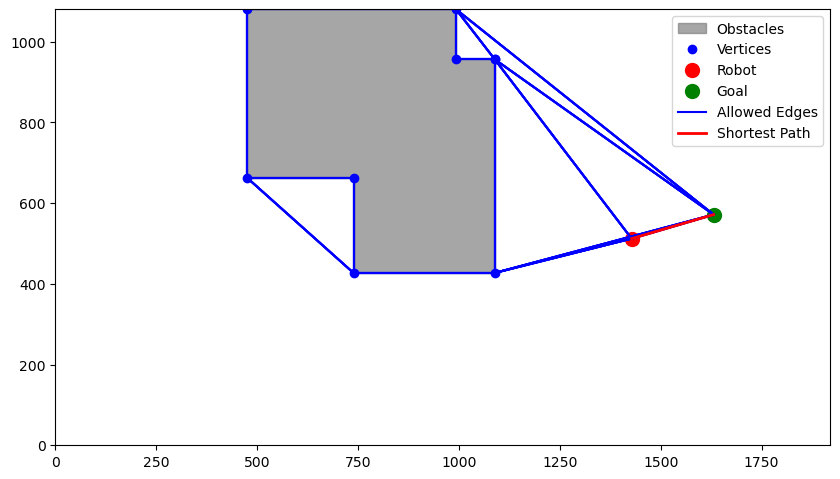

centroid camera:  (77, 27)
glob nav path : [(88, 30)]
Iteration :  224
Kalman:  x:  77.0001725900053 , y:  27.000449787592288 , angle:  0.28034811178394226
Rotation state:
Robot angle:  [0.28034811] , Goal angle:  [0.26621797] , Rotation to achieve:  [-0.01413014]
Iteration :  225
Kalman:  x:  77.20577605177995 , y:  27.059648253188993 , angle:  0.2804595942677007
Translation state:
Error =  [11.18753498]
Iteration :  226
Kalman:  x:  77.7503490743497 , y:  27.21658229180918 , angle:  0.2830267964042499
Translation state:
Error =  [10.62086429]
Iteration :  227
Kalman:  x:  78.22781784065822 , y:  27.35545743805278 , angle:  0.28281206488145383
Translation state:
Error =  [10.12369248]
Iteration :  228
Kalman:  x:  79.03057825726967 , y:  27.587698831391293 , angle:  0.28483178129053477
Translation state:
Error =  [9.28814962]
Iteration :  229
Kalman:  x:  79.96679627120155 , y:  27.86433828111781 , angle:  0.28394538175142464
Translation state:
Error =  [8.31224477]
Iteration :  230
K

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 

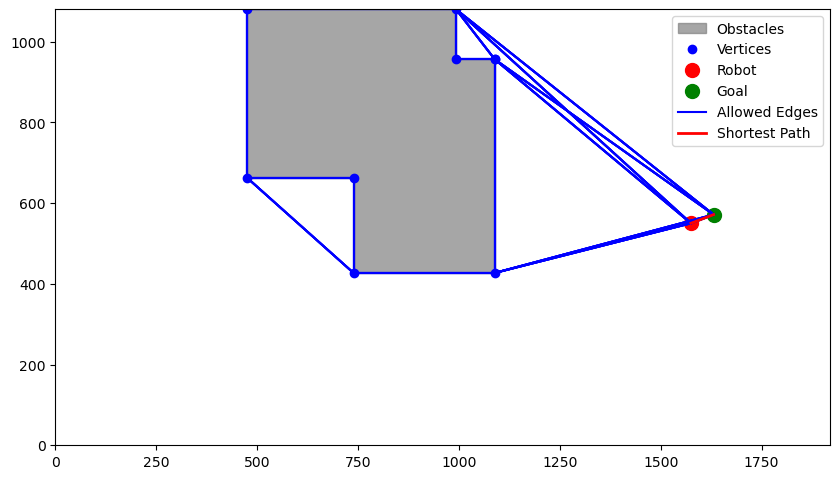

centroid camera:  (85, 29)
glob nav path : [(88, 30)]
Iteration :  239
Kalman:  x:  85.00098227972931 , y:  29.000387104323035 , angle:  0.2990584111313242
Rotation state:
Robot angle:  [0.29905841] , Goal angle:  [0.32173265] , Rotation to achieve:  [0.02267423]
Iteration :  240
Kalman:  x:  85.15831151740366 , y:  29.048890008696574 , angle:  0.29956737744443446
Translation state:
Error =  [2.99663205]
Iteration :  241
Kalman:  x:  85.67276595232866 , y:  29.207883416520538 , angle:  0.3032188973557494
Translation state:
Error =  [2.45834639]
Iteration :  242
Kalman:  x:  86.13181519352858 , y:  29.351461629376416 , angle:  0.30339813673186056
Translation state:
Error =  [1.97755316]
Iteration :  243
Kalman:  x:  86.886354565953 , y:  29.587981310153165 , angle:  0.3007768698105189
Translation state:
Error =  [1.1874197]
Iteration :  244
Kalman:  x:  87.82328197199573 , y:  29.877821656360144 , angle:  0.2991808113734511
Translation state:
Error =  [0.21484136]
Thymio stopped while u

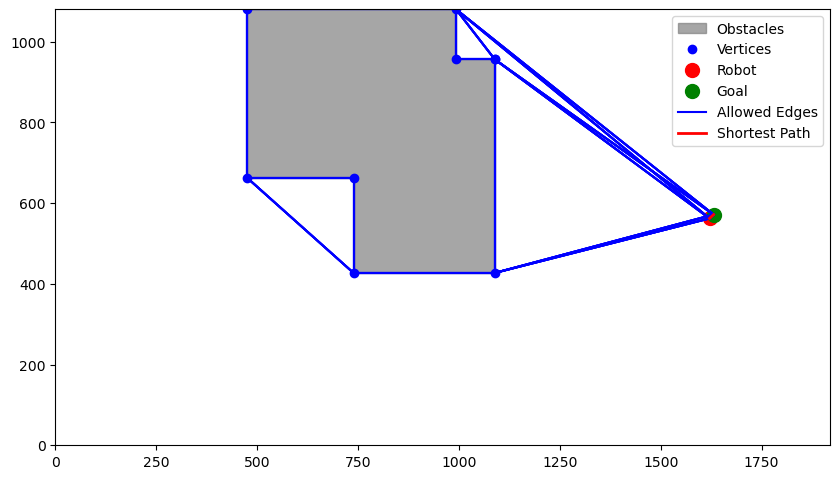

centroid camera:  (87, 30)
glob nav path : []
Iteration :  246
Thymio arrived in the goal area, congratulations!


In [24]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

old_time = 0.0
iter = 0


while(cap.isOpened()):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman 
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    
    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

        
    #CA SERT A QUOI RAPH? A mettre dans une fonction?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        # Compute the difference between the robot direction and the direction of the goal
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], 
                           intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        # Define the turning orientation
        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

        # Check the orientation of the robot
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
        
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        # Check if the robot achieve the intermediate goal
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        # Check if the robot orientation change a lot from its goal direction
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0,0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            ret, frame = cap.read()
            robot_centroid, robot_direction = vision.vision_robot(frame)
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        
        # Convert in centimeter for the Kalman filter
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        # Delete the first goal because it's the robot position
        intermediate_goals.pop(0)
        
        # Check if the robot achieve the next goal, if yes it can target the next one
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        # Check if we detect an already known obstacle or an other one
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        # Add the new obstacle to the list
        obstacles.append(Object)
        prox_sensors_bool = True
        
        # The robot is backwarding in order to avoid the obstacle
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [11]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE